In [7]:
import sagemaker
import boto3
from sagemaker import image_uris

# Session setup
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
region = session.boto_region_name

# Get the XGBoost container image
xgb_image = image_uris.retrieve('xgboost', region, version='1.7-1')

print(f"Role: {role}")
print(f"Bucket: {bucket}")
print(f"Region: {region}")
print(f"XGBoost image: {xgb_image}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Role: arn:aws:iam::360138725243:role/service-role/AmazonSageMaker-ExecutionRole-20260206T133954
Bucket: sagemaker-us-east-1-360138725243
Region: us-east-1
XGBoost image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [8]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

# Configure the XGBoost estimator
xgb = Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/models/',
    sagemaker_session=session,
    base_job_name='insurance-lapse-xgb'
)

# Set hyperparameters
xgb.set_hyperparameters(
    objective='binary:logistic',
    num_round=200,
    max_depth=5,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=4,
    eval_metric='auc'
)

# Point to training and validation data
train_input = TrainingInput(
    s3_data=f's3://{bucket}/data/processed/train/',
    content_type='text/csv'
)
val_input = TrainingInput(
    s3_data=f's3://{bucket}/data/processed/validation/',
    content_type='text/csv'
)

# Launch the training job
xgb.fit({'train': train_input, 'validation': val_input})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: insurance-lapse-xgb-2026-02-09-21-32-08-699


2026-02-09 21:32:09 Starting - Starting the training job...
2026-02-09 21:32:25 Starting - Preparing the instances for training...
2026-02-09 21:32:48 Downloading - Downloading input data...
2026-02-09 21:33:33 Downloading - Downloading the training image......
2026-02-09 21:34:39 Training - Training image download completed. Training in progress.../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-09 21:34:41.782 ip-10-2-193-102.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-09 21:34:41.848 ip-10-2-193-102.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-09:21:34:42:INFO] Imported framework sagemaker_xgboost_container.trai

In [10]:
import pandas as pd
import numpy as np
from sagemaker.deserializers import CSVDeserializer

# Deploy a temporary endpoint for predictions
predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=CSVDeserializer()
)

print("Endpoint deployed successfully!")

INFO:sagemaker:Creating model with name: insurance-lapse-xgb-2026-02-09-21-37-09-520
INFO:sagemaker:Creating endpoint-config with name insurance-lapse-xgb-2026-02-09-21-37-09-520
INFO:sagemaker:Creating endpoint with name insurance-lapse-xgb-2026-02-09-21-37-09-520


------!Endpoint deployed successfully!


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Column names (Lapsed first now)
col_names = ['Lapsed', 'Distribution_channel', 'Seniority', 'Policies_in_force', 
             'Max_policies', 'Max_products', 'Payment', 'Premium', 'Cost_claims_year',
             'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk', 
             'Area', 'Second_driver', 'Year_matriculation', 'Power', 'Cylinder_capacity',
             'Value_vehicle', 'N_doors', 'Type_fuel', 'Length', 'Weight', 'Age', 
             'Years_driving', 'Customer_tenure_days']

# Load validation data (no header)
val_df = pd.read_csv(f's3://{bucket}/data/processed/validation/validation.csv', 
                     header=None, names=col_names)

# Separate target from features
val_y = val_df['Lapsed'].values
val_X = val_df.drop(columns=['Lapsed'])

# Get predictions from the endpoint
predictions = []
batch_size = 500

for i in range(0, len(val_X), batch_size):
    batch = val_X.iloc[i:i+batch_size]
    csv_batch = batch.to_csv(header=False, index=False)
    response = predictor.predict(csv_batch)
    predictions.extend([float(p[0]) for p in response])

# Convert probabilities to binary predictions (threshold = 0.5)
pred_probs = np.array(predictions)
pred_labels = (pred_probs >= 0.5).astype(int)

# Classification report
print(classification_report(val_y, pred_labels, target_names=['Not Lapsed', 'Lapsed']))

              precision    recall  f1-score   support

  Not Lapsed       0.93      0.80      0.86     16744
      Lapsed       0.50      0.77      0.61      4367

    accuracy                           0.79     21111
   macro avg       0.72      0.78      0.73     21111
weighted avg       0.84      0.79      0.81     21111



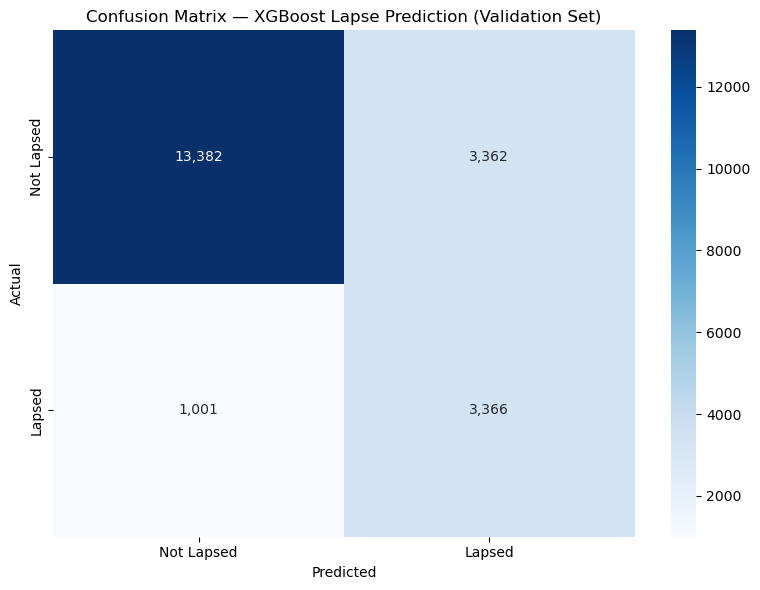


True Negatives:  13,382 (correctly predicted NOT lapsed)
False Positives: 3,362 (predicted lapsed, but actually stayed)
False Negatives: 1,001 (predicted stayed, but actually lapsed)
True Positives:  3,366 (correctly predicted lapsed)


In [12]:
# Confusion matrix
cm = confusion_matrix(val_y, pred_labels)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues',
            xticklabels=['Not Lapsed', 'Lapsed'],
            yticklabels=['Not Lapsed', 'Lapsed'], ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix — XGBoost Lapse Prediction (Validation Set)')
plt.tight_layout()
plt.savefig('../confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTrue Negatives:  {cm[0][0]:,} (correctly predicted NOT lapsed)")
print(f"False Positives: {cm[0][1]:,} (predicted lapsed, but actually stayed)")
print(f"False Negatives: {cm[1][0]:,} (predicted stayed, but actually lapsed)")
print(f"True Positives:  {cm[1][1]:,} (correctly predicted lapsed)")

In [13]:
predictor.delete_endpoint()
print("Endpoint deleted — no more charges!")

INFO:sagemaker:Deleting endpoint configuration with name: insurance-lapse-xgb-2026-02-09-21-37-09-520
INFO:sagemaker:Deleting endpoint with name: insurance-lapse-xgb-2026-02-09-21-37-09-520


Endpoint deleted — no more charges!
